<a href="https://colab.research.google.com/github/LeandroMurillo/TrabajoFinalPDS/blob/main/TFI_PDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inicialización del repositorio**

In [1]:
import os

# === CONFIGURACIÓN ===
REPO_URL = "https://github.com/LeandroMurillo/TrabajoFinalPDS"
REPO_DIR = "/content/TrabajoFinalPDS"

# === Paso 1: Intentar obtener el token desde los secretos de Colab ===
try:
    from google.colab import userdata
    token = userdata.get('GITHUB_TOKEN')
except:
    token = None

# === Paso 2: Construir la URL del repo según si hay token (para autenticación) ===
if token:
    clone_url = f"https://{token}@github.com/LeandroMurillo/TrabajoFinalPDS"
else:
    clone_url = REPO_URL  # acceso público solo lectura

# === Paso 3: Clonar el repositorio si no existe ===
if not os.path.exists(REPO_DIR):
    os.chdir("/content")
    !git clone {clone_url}

# === Paso 4: Si hay token, configurar el remote para futuras acciones autenticadas ===
os.chdir(REPO_DIR)
if token:
    !git remote set-url origin https://{token}@github.com/LeandroMurillo/TrabajoFinalPDS

print("Repositorio listo. Ya podés trabajar con Git.")


Cloning into 'TrabajoFinalPDS'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 2.80 MiB | 10.10 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Repositorio listo. Ya podés trabajar con Git.


Trabajo

In [2]:
# === CONFIGURACIÓN E IMPORTS ===

# --- Manipulación numérica ---
import numpy as np
from copy import deepcopy
import time

# --- Visualización ---
import matplotlib.pyplot as plt

# --- Señales y filtros ---
from scipy.io import loadmat
from scipy.signal import (
    buttord, butter, bilinear, cont2discrete,
    freqz, freqs, find_peaks, lfilter, tf2zpk, tf2sos
)
from scipy.fft import fft, fftfreq, rfft, rfftfreq


In [3]:
# === CARGA Y VISUALIZACIÓN DE SEÑALES ===

# --- Parámetros generales ---
fs = 360  # Frecuencia de muestreo en Hz

# --- Ruta del archivo .mat (ajustar si es necesario) ---
archivo_mat = "/content/TrabajoFinalPDS/ecg_signal.mat"

# --- Carga del archivo ---
mat_data = loadmat(archivo_mat)

# --- Extracción y conversión a milivoltios ---
senal1 = mat_data["ecg_signal1"].squeeze()
senal2 = mat_data["ecg_signal2"].squeeze()
senal3 = mat_data["ecg_signal3"].squeeze()
senales = [senal1, senal2, senal3]

def graficar_senal_completa(senal, fs, titulo="Señal en el tiempo"):
    """
    Grafica una señal completa en el dominio del tiempo.
    """
    tiempo = np.arange(len(senal)) / fs
    plt.figure(figsize=(14, 4))
    plt.plot(tiempo, senal, label="Señal completa")
    plt.title(titulo)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True)
    plt.xlim(0, tiempo[-1])
    plt.xticks(np.arange(0, tiempo[-1] + 1, 1))
    locs, _ = plt.yticks()
    plt.yticks(locs, [f"{val:.3f}" for val in locs])
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
def graficar_fft(
    senal,
    fs,
    escala='dB',
    normalizar=False,
    titulo="Espectro de Frecuencia"
):
    """
    Grafica la FFT de una señal real con línea continua.

    Parámetros:
    - senal: array 1D con la señal a analizar.
    - fs: frecuencia de muestreo en Hz.
    - escala: 'dB' o 'lineal'
    - normalizar: si True, escala el espectro para que el pico sea 0 dB o 1.
    - titulo: título del gráfico.
    """
    n = len(senal)
    X = rfft(senal)
    freqs = rfftfreq(n, d=1/fs)

    if escala == 'dB':
        mag = np.abs(X)
        if normalizar:
            mag = mag / np.max(mag)
        Y = 20 * np.log10(mag + 1e-12)
        ylabel = 'Magnitud [dB]'
        ylim = (np.min(Y), 0)
    elif escala == 'lineal':
        Y = np.abs(X)
        if normalizar:
            Y = Y / np.max(Y)
        ylabel = 'Magnitud (lineal)'
        ylim = None
    else:
        raise ValueError("Escala debe ser 'dB' o 'lineal'.")

    df = fs / n
    print(f"Resolución espectral: Δf = {df:.4f} Hz")

    plt.figure(figsize=(10, 4))
    plt.plot(freqs, Y, linewidth=1)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel(ylabel)
    plt.title(titulo)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlim(0, fs / 2)
    if ylim:
        plt.ylim(*ylim)
    plt.tight_layout()
    plt.show()

def graficar_un_ciclo(senal, fs, titulo="Un ciclo cardíaco (PQRST)"):
    """
    Detecta el primer pico R y grafica una ventana alrededor del ciclo completo.

    Parámetros:
    - senal: señal ECG en milivoltios.
    - fs: frecuencia de muestreo en Hz.
    - titulo: título del gráfico.
    """
    # Detección de picos R
    altura_minima = 0.5 * (np.max(senal) - np.min(senal)) + np.min(senal)
    distancia_minima = int(0.25 * fs)
    picos, _ = find_peaks(senal, height=altura_minima, distance=distancia_minima)

    if len(picos) == 0:
        print("No se detectaron picos R.")
        return

    # Selección de ventana temporal alrededor del primer pico
    centro = picos[0]
    pre = int(0.2 * fs)   # 200 ms antes
    post = int(0.4 * fs)  # 400 ms después
    inicio = max(0, centro - pre)
    fin = min(len(senal), centro + post)
    tiempo = np.arange(inicio, fin) / fs

    # Gráfica
    plt.figure(figsize=(14, 4))
    plt.plot(tiempo, senal[inicio:fin], label="Ciclo PQRST")
    plt.title(titulo)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Diseño de filtro pasabajos

In [5]:
def diseñar_filtro_analogico(fp, fs_rechazo, Ap, As, metodo_prewarp=False, fs=None):
    """
    Diseña un filtro analógico pasa bajos de Butterworth.

    Si `metodo_prewarp` es True, aplica prewarping para que sea compatible con la transformación bilineal.

    Retorna: (b, a), orden del filtro, frecuencias de corte analógicas
    """
    if metodo_prewarp and fs is not None:
        wp = 2 * fs * np.tan(np.pi * fp / fs)
        ws = 2 * fs * np.tan(np.pi * fs_rechazo / fs)
    else:
        wp = 2 * np.pi * fp
        ws = 2 * np.pi * fs_rechazo

    n, wn = buttord(wp, ws, Ap, As, analog=True)
    b, a = butter(n, wn, btype='low', analog=True)
    return b, a, n, wn

def transformar_bilineal(b, a, fs):
    """
    Transforma una función de transferencia analógica a digital usando el método bilineal.
    """
    return bilinear(b, a, fs)

def transformar_invarianza(b, a, fs):
    """
    Transforma una función de transferencia analógica a digital usando la invarianza al impulso.
    """
    dt = 1 / fs
    bz, az, _ = cont2discrete((b, a), dt, method='impulse')
    return bz.flatten(), az

def calcular_frecuencias_digitales_warp(wp, ws, fs):
    """
    Convierte frecuencias analógicas (rad/s) en frecuencias digitales (Hz) después del prewarping.
    """
    wp = np.array(wp)
    ws = np.array(ws)
    fp_digital = (fs / np.pi) * np.arctan(wp / (2 * fs))
    fs_digital = (fs / np.pi) * np.arctan(ws / (2 * fs))
    return fp_digital, fs_digital


In [6]:
# === PARÁMETROS DEL FILTRO PASA BAJOS ===
fp = 30      # Frecuencia de paso deseada [Hz]
fb = 80      # Frecuencia de rechazo deseada [Hz]
Ap = 0.5     # Atenuación máxima en banda de paso [dB]
As = 20      # Atenuación mínima en banda de rechazo [dB]

# === 1. Diseño del filtro analógico (sin prewarping) ===
b_analog, a_analog, orden, wn = diseñar_filtro_analogico(fp, fb, Ap, As)
print(f"Orden del filtro analógico: {orden}")
print(f"Frecuencia de corte analógica: {wn:.2f} rad/s ({wn / (2 * np.pi):.2f} Hz)")

# === 2. Transformaciones digitales ===
bz_bilin, az_bilin = transformar_bilineal(b_analog, a_analog, fs)
bz_invar, az_invar = transformar_invarianza(b_analog, a_analog, fs)

# === 3. Obtener frecuencias digitales equivalentes (solo útil para bilineal) ===
wp = 2 * np.pi * fp
ws = 2 * np.pi * fb
fp_bilin, fb_bilin = calcular_frecuencias_digitales_warp(wp, ws, fs)


Orden del filtro analógico: 4
Frecuencia de corte analógica: 245.19 rad/s (39.02 Hz)


In [7]:
def graficar_respuesta_frecuencia_comparada(b, a, bz, az, fs, fp, fs_rechazo, metodo=""):
    """
    Compara la respuesta en frecuencia (dB) del filtro analógico y su versión digital.

    Parámetros:
    - b, a: coeficientes del filtro analógico.
    - bz, az: coeficientes del filtro digital.
    - fs: frecuencia de muestreo (Hz).
    - fp: frecuencia de paso digital (Hz).
    - fs_rechazo: frecuencia de rechazo digital (Hz).
    - metodo: nombre del método digital ("Bilineal", "Invarianza", etc.)
    """
    w_analog = np.linspace(0.01, fs * np.pi, 1000)
    frecs_analog = w_analog / (2 * np.pi)
    _, h_analog = freqs(b, a, w_analog)
    h_analog_db = 20 * np.log10(np.abs(h_analog))

    w_digital, h_digital = freqz(bz, az, worN=1024)
    frecs_digital = w_digital * fs / (2 * np.pi)
    h_digital_db = 20 * np.log10(np.abs(h_digital))

    plt.figure(figsize=(12, 5))
    plt.plot(frecs_analog, h_analog_db, label="Filtro Analógico", linewidth=2)
    plt.plot(frecs_digital, h_digital_db, '--', label=f"Filtro Digital ({metodo})", linewidth=2)

    # Líneas de referencia para frecuencias de paso y rechazo
    for fpi in np.atleast_1d(fp):
        plt.axvline(fpi, color="green", linestyle=":", label=f"fp ≈ {fpi:.2f} Hz")
    for fsi in np.atleast_1d(fs_rechazo):
        plt.axvline(fsi, color="red", linestyle=":", label=f"fs ≈ {fsi:.2f} Hz")

    plt.title(f"Comparación: Filtro Analógico vs. Digital ({metodo})")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Magnitud [dB]")
    plt.grid(True)
    plt.xlim(0, fs / 2)
    plt.ylim(-60, 5)
    plt.legend()
    plt.tight_layout()
    plt.show()


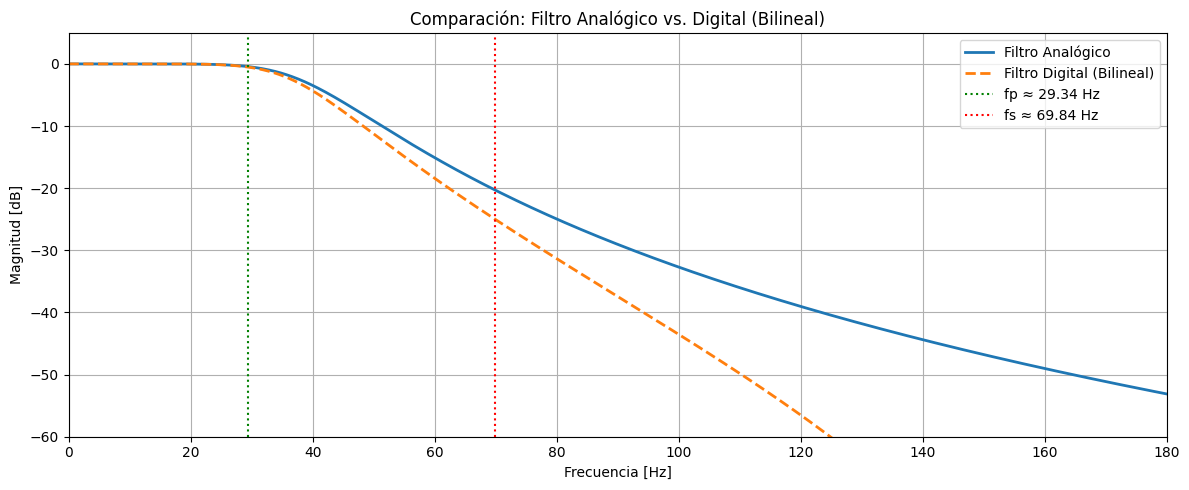

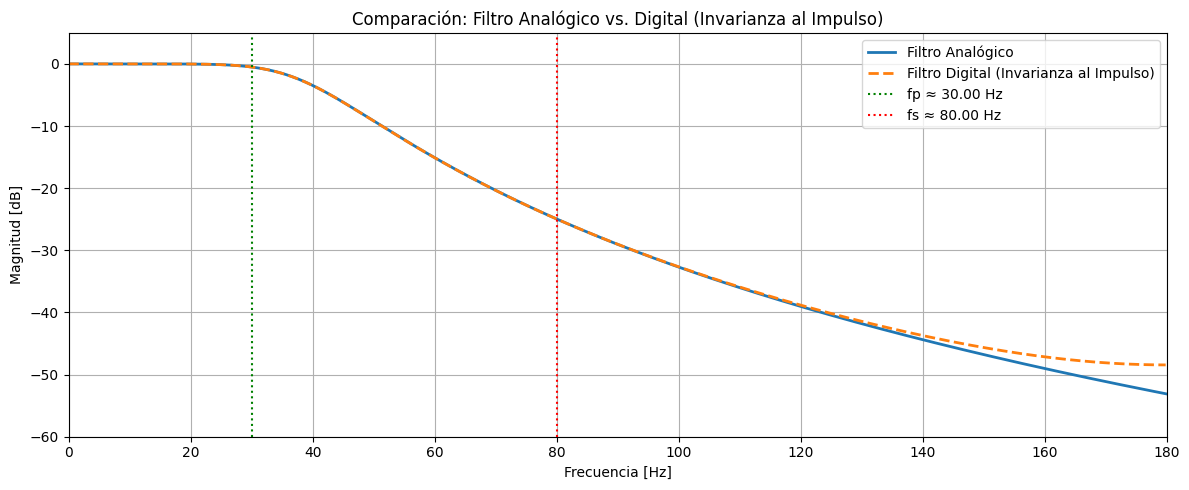

In [8]:
# === 4. Comparar respuesta en frecuencia de ambos métodos ===
graficar_respuesta_frecuencia_comparada(
    b_analog, a_analog,
    bz_bilin, az_bilin,
    fs,
    fp=fp_bilin,
    fs_rechazo=fb_bilin,
    metodo="Bilineal"
)

graficar_respuesta_frecuencia_comparada(
    b_analog, a_analog,
    bz_invar, az_invar,
    fs,
    fp=fp,     # No hay prewarping en invarianza
    fs_rechazo=fb,
    metodo="Invarianza al Impulso"
)


In [9]:
def graficar_polos_ceros_digitales_separados(bz1, az1, bz2, az2, metodo1="Método 1", metodo2="Método 2"):
    """
    Grafica los diagramas de polos y ceros en el plano Z de dos filtros digitales.

    Parámetros:
    - bz1, az1: coeficientes del primer filtro digital
    - bz2, az2: coeficientes del segundo filtro digital
    - metodo1, metodo2: etiquetas para cada filtro
    """
    z1, p1, _ = tf2zpk(bz1, az1)
    z2, p2, _ = tf2zpk(bz2, az2)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    for ax, z, p, metodo in zip(axs, [z1, z2], [p1, p2], [metodo1, metodo2]):
        ax.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='tab:blue', label='Ceros')
        ax.scatter(np.real(p), np.imag(p), marker='x', color='tab:red', label='Polos')

        # Circunferencia unidad
        theta = np.linspace(0, 2 * np.pi, 400)
        ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unidad')

        ax.axhline(0, color='gray', linewidth=0.5)
        ax.axvline(0, color='gray', linewidth=0.5)
        ax.set_title(f"Plano Z - {metodo}")
        ax.set_xlabel("Re")
        ax.set_ylabel("Im")
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.legend()

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/scipy/signal/_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


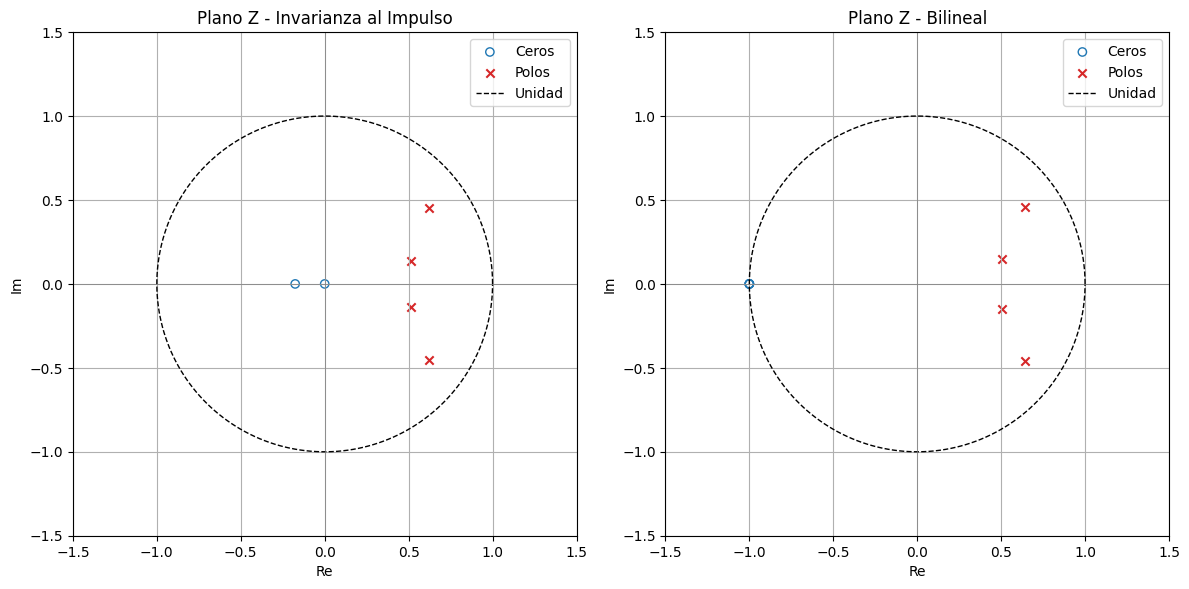

In [10]:
graficar_polos_ceros_digitales_separados(
    bz_invar, az_invar,
    bz_bilin, az_bilin,
    metodo1="Invarianza al Impulso",
    metodo2="Bilineal"
)


In [11]:
def graficar_ciclo_filtrado(senales, bz, az, fs, metodo=""):
    """
    Aplica el filtro digital (bz, az) a cada señal y grafica un ciclo PQRST comparando
    señal original vs señal filtrada.

    Parámetros:
    - senales: lista de señales ECG
    - bz, az: coeficientes del filtro digital
    - fs: frecuencia de muestreo en Hz
    - metodo: nombre del método digital (para el título)
    """
    for i, senal in enumerate(senales, 1):
        salida = lfilter(bz, az, senal)

        altura_minima = 0.5 * (np.max(senal) - np.min(senal)) + np.min(senal)
        distancia_minima = int(0.25 * fs)
        picos, _ = find_peaks(senal, height=altura_minima, distance=distancia_minima)

        if len(picos) == 0:
            print(f"No se detectaron picos R en la señal {i}.")
            continue

        centro = picos[0]
        pre = int(0.2 * fs)
        post = int(0.4 * fs)
        inicio = max(0, centro - pre)
        fin = min(len(senal), centro + post)
        tiempo = np.arange(inicio, fin) / fs

        plt.figure(figsize=(14, 4))
        plt.plot(tiempo, senal[inicio:fin], label="Original", alpha=0.7)
        plt.plot(tiempo, salida[inicio:fin], label=f"Filtrada ({metodo})", alpha=0.8)
        plt.title(f"Señal ECG {i}: Original vs Filtrada ({metodo})")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud [mV]")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


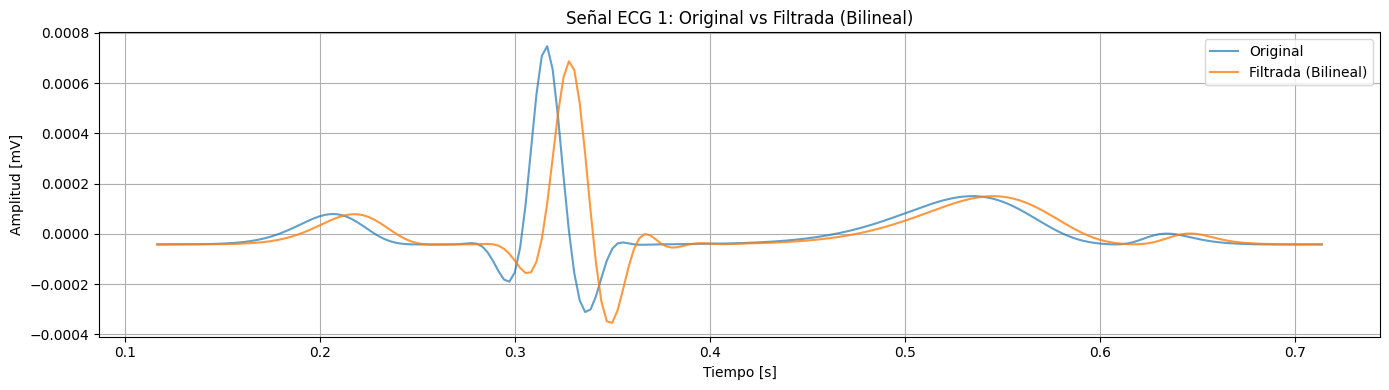

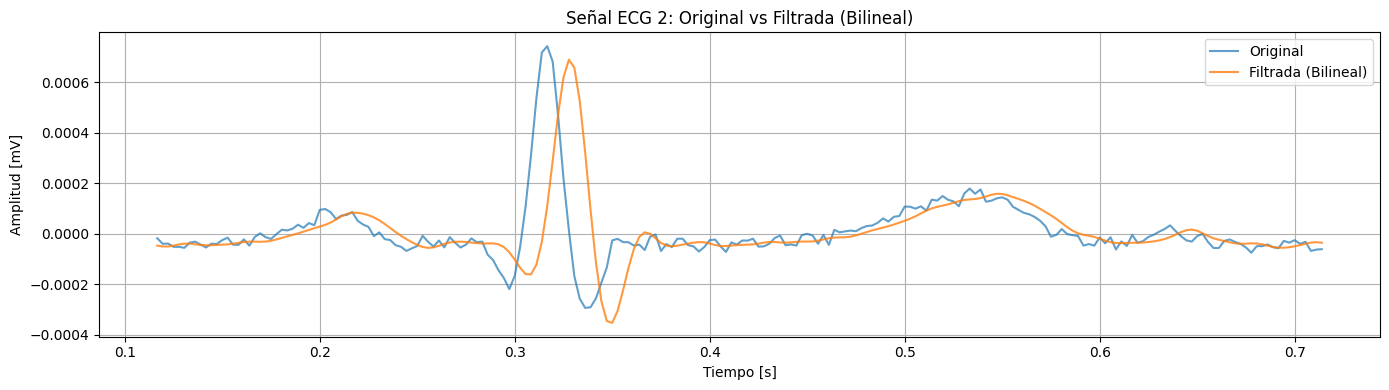

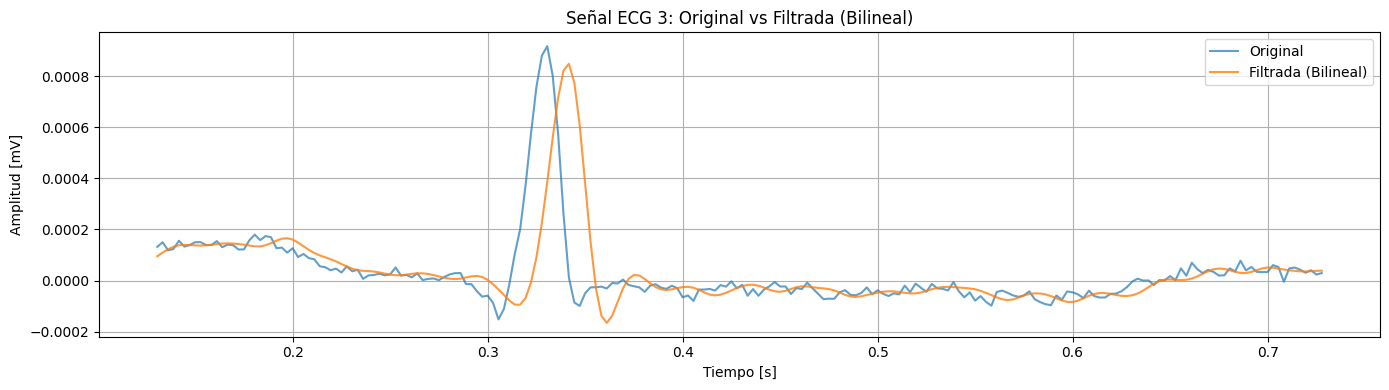

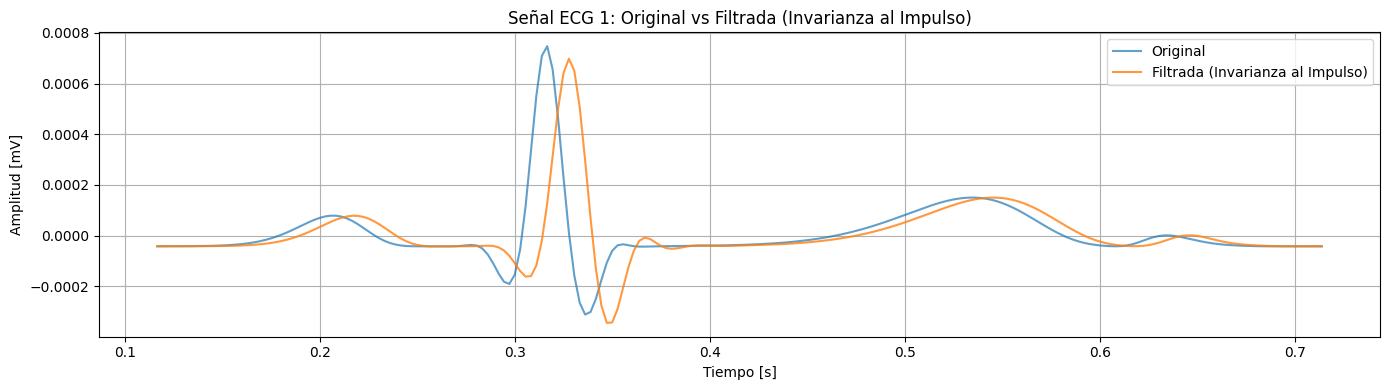

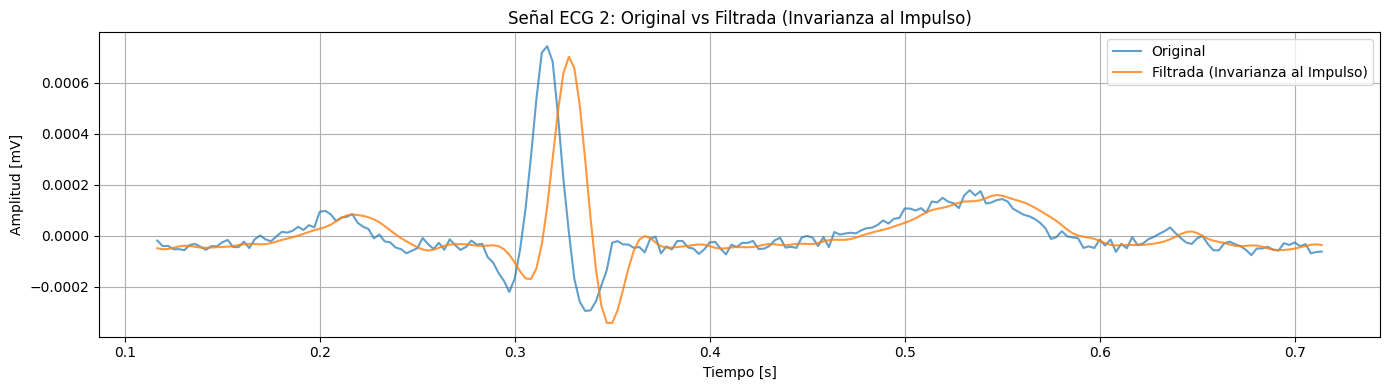

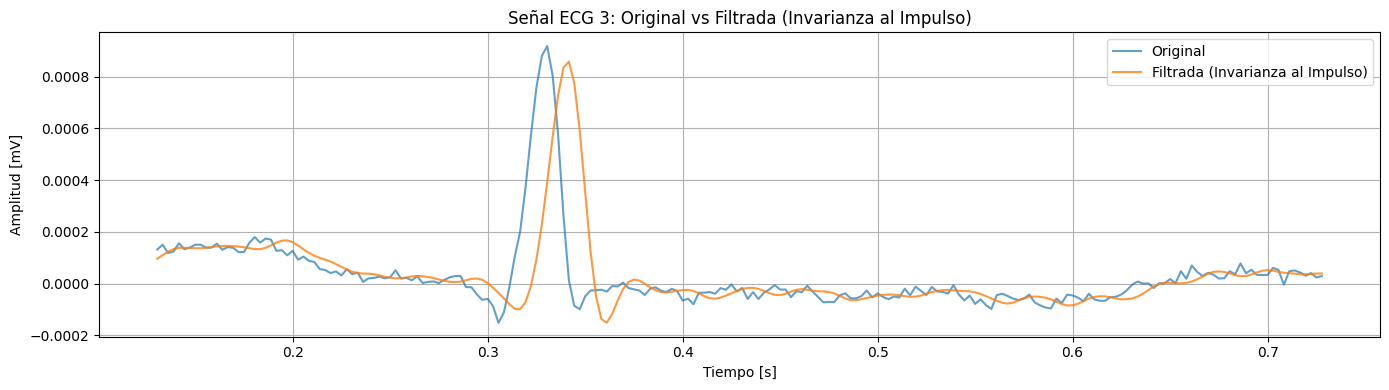

In [12]:
# === Aplicación de filtro bilineal a señales ===
senales_filtradas_bilin = [lfilter(bz_bilin, az_bilin, s) for s in senales]

# === Aplicación de filtro por invarianza ===
senales_filtradas_invar = [lfilter(bz_invar, az_invar, s) for s in senales]

# === Visualización de un ciclo filtrado ===
graficar_ciclo_filtrado(senales, bz_bilin, az_bilin, fs, metodo="Bilineal")
graficar_ciclo_filtrado(senales, bz_invar, az_invar, fs, metodo="Invarianza al Impulso")


In [13]:
def graficar_fft_comparativa(senales, senales_filtradas, fs, fmax=None, metodo=""):
    """
    Grafica el espectro de magnitud (en dB) de cada señal original y su versión filtrada.

    Parámetros:
    - senales: lista de señales originales
    - senales_filtradas: lista de señales filtradas
    - fs: frecuencia de muestreo (Hz)
    - fmax: frecuencia máxima a mostrar (Hz)
    - metodo: nombre del método del filtro (para el título)
    """
    for i, (senal, salida) in enumerate(zip(senales, senales_filtradas), 1):
        N = len(senal)
        espectro_orig = fft(senal)
        espectro_filt = fft(salida)
        frecs = fftfreq(N, 1 / fs)
        idx = frecs > 0
        frecs = frecs[idx]

        espectro_orig_db = 20 * np.log10(np.abs(espectro_orig[idx]) + 1e-12)
        espectro_filt_db = 20 * np.log10(np.abs(espectro_filt[idx]) + 1e-12)

        if fmax is None:
            fmax = fs / 2

        # Tomar el mayor valor entre ambos espectros para escalar el eje Y
        ymax = max(np.max(espectro_orig_db), np.max(espectro_filt_db))
        ymin = ymax - 80

        plt.figure(figsize=(14, 4))

        # Espectro original
        plt.subplot(1, 2, 1)
        plt.plot(frecs, espectro_orig_db, linewidth=1, label="Original", color="tab:blue")
        plt.title(f"ECG {i} - Original")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Magnitud [dB]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        # Espectro filtrado
        plt.subplot(1, 2, 2)
        plt.plot(frecs, espectro_filt_db, linewidth=1, label=f"Filtrada ({metodo})", color="tab:orange")
        plt.title(f"ECG {i} - Filtrada ({metodo})")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.tight_layout()
        plt.show()


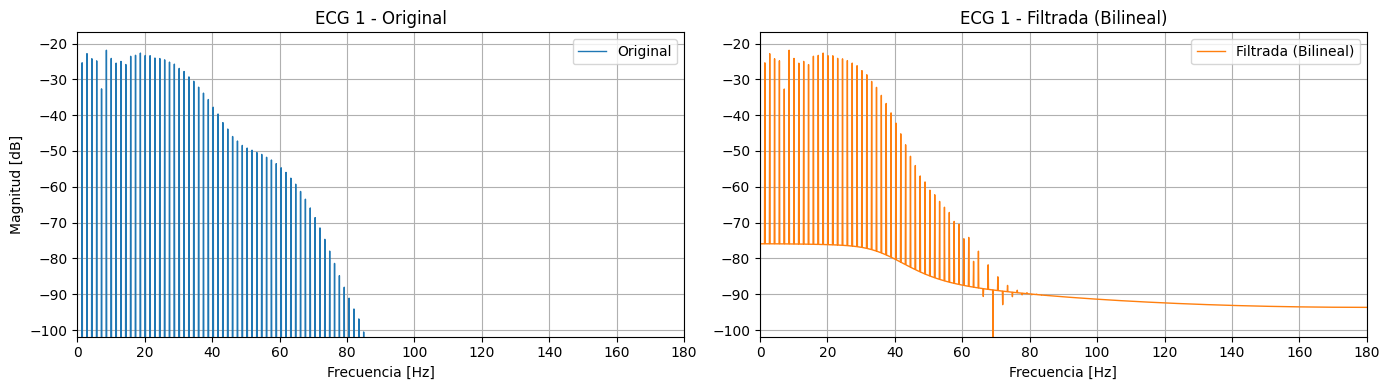

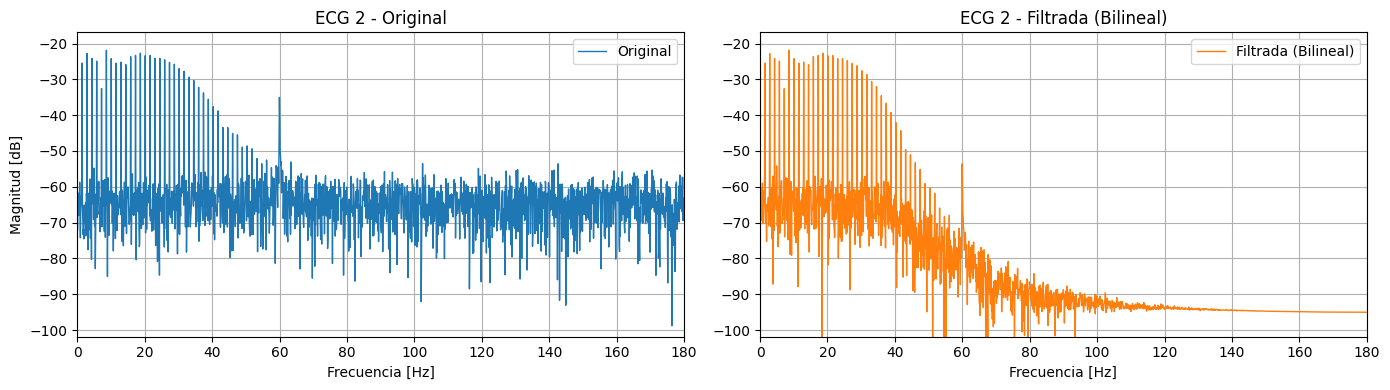

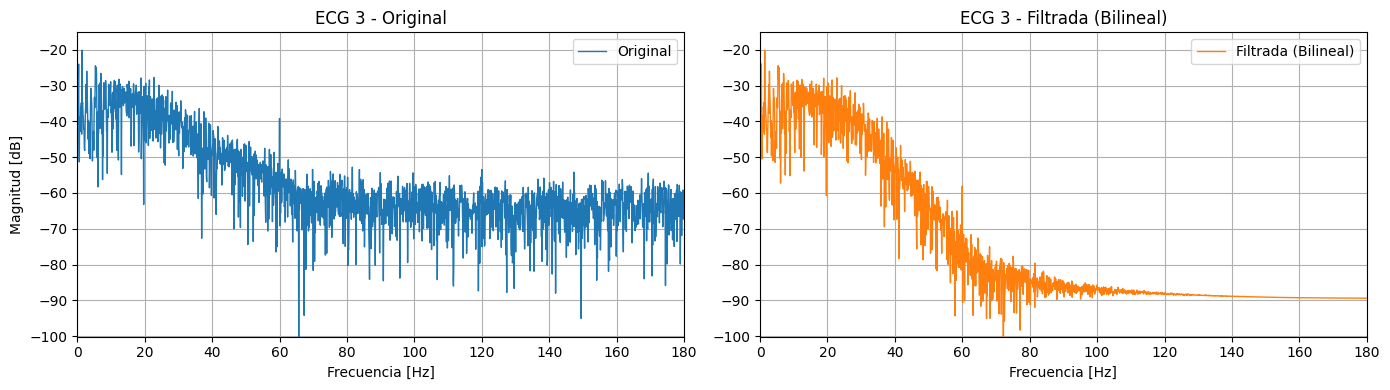

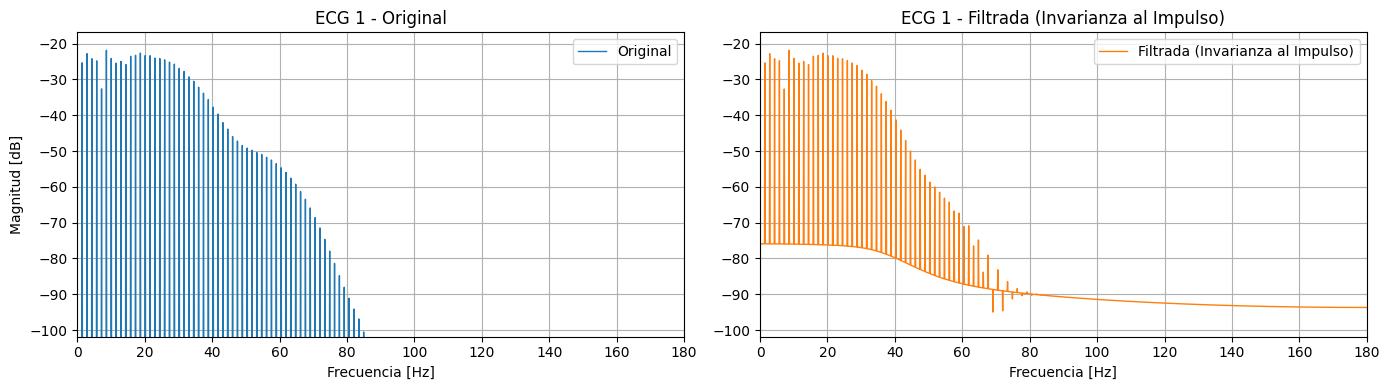

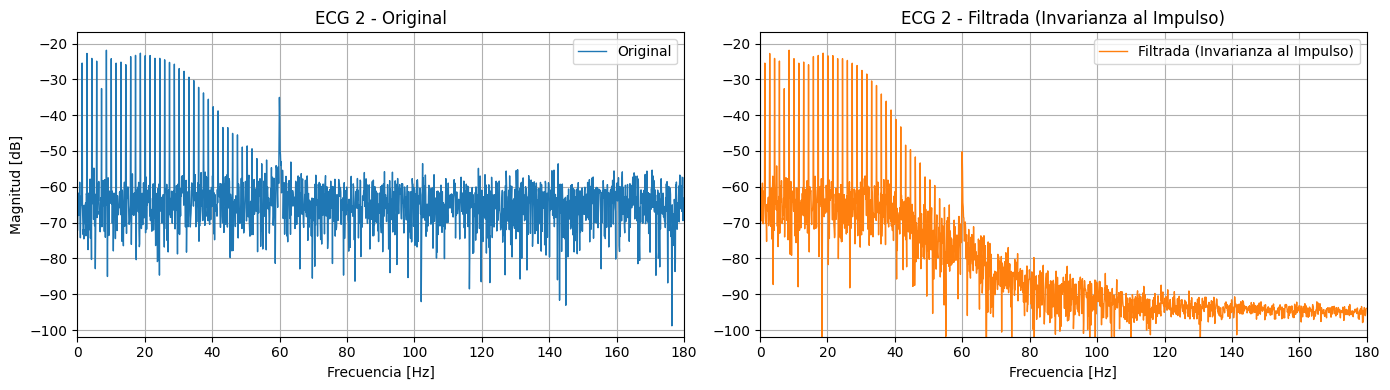

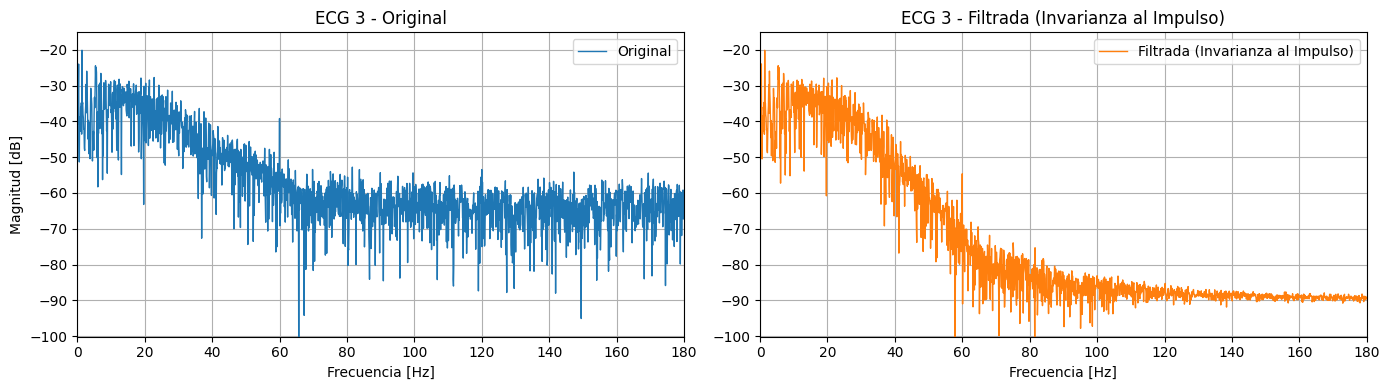

In [14]:
graficar_fft_comparativa(
    senales,
    senales_filtradas_bilin,
    fs,
    fmax=180,
    metodo="Bilineal"
)

graficar_fft_comparativa(
    senales,
    senales_filtradas_invar,
    fs,
    fmax=180,
    metodo="Invarianza al Impulso"
)


In [15]:
def graficar_fase_en_columnas(senales, senales_filtradas_invar, senales_filtradas_bilin, fs, fmax=None):
    """
    Grafica la fase espectral (en radianes) para:
      - Señal original,
      - Señal filtrada con invarianza,
      - Señal filtrada con bilineal.

    Cada señal se presenta en una figura con tres subgráficos (una columna por método).
    """
    for i, (x, y_invar, y_bilin) in enumerate(zip(senales, senales_filtradas_invar, senales_filtradas_bilin), 1):
        N = len(x)

        X = fft(x)
        Y_invar = fft(y_invar)
        Y_bilin = fft(y_bilin)

        frecs = fftfreq(N, 1/fs)
        idx_pos = frecs > 0
        frecs = frecs[idx_pos]
        X = X[idx_pos]
        Y_invar = Y_invar[idx_pos]
        Y_bilin = Y_bilin[idx_pos]

        fase_X = np.unwrap(np.angle(X))
        fase_invar = np.unwrap(np.angle(Y_invar))
        fase_bilin = np.unwrap(np.angle(Y_bilin))

        if fmax is not None:
            idx_limit = frecs <= fmax
            frecs = frecs[idx_limit]
            fase_X = fase_X[idx_limit]
            fase_invar = fase_invar[idx_limit]
            fase_bilin = fase_bilin[idx_limit]

        plt.figure(figsize=(18, 4))

        plt.subplot(1, 3, 1)
        plt.plot(frecs, fase_X, color="tab:blue")
        plt.title(f"ECG {i} - Fase Original")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Fase [rad]")
        plt.grid(True)
        plt.xlim(0, fmax or fs/2)

        plt.subplot(1, 3, 2)
        plt.plot(frecs, fase_invar, color="tab:orange")
        plt.title(f"ECG {i} - Fase Invarianza")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax or fs/2)

        plt.subplot(1, 3, 3)
        plt.plot(frecs, fase_bilin, color="tab:green")
        plt.title(f"ECG {i} - Fase Bilineal")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax or fs/2)

        plt.tight_layout()
        plt.show()


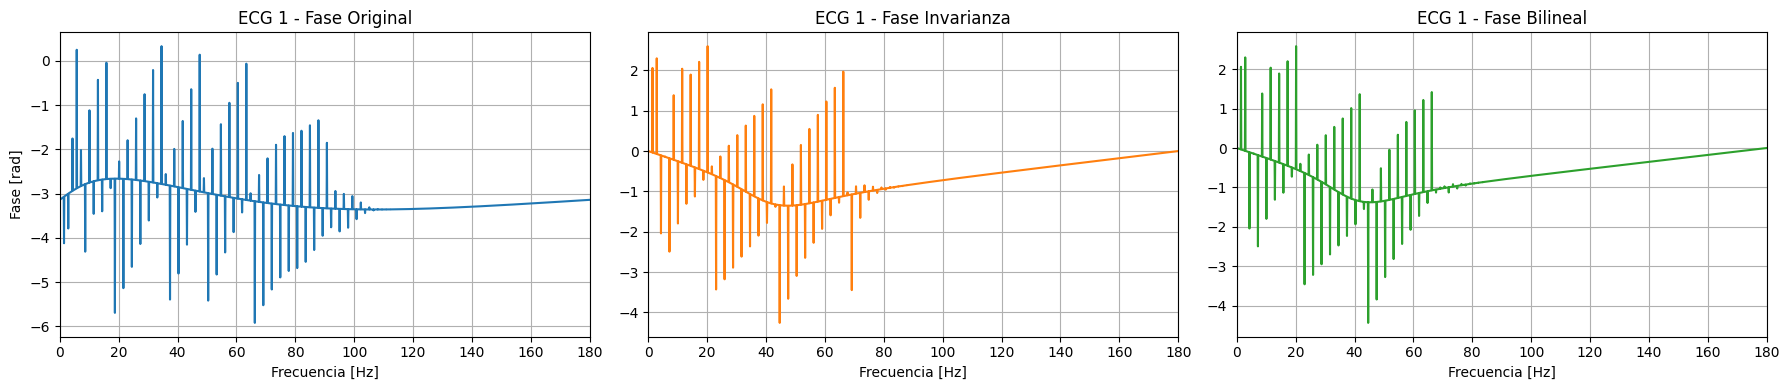

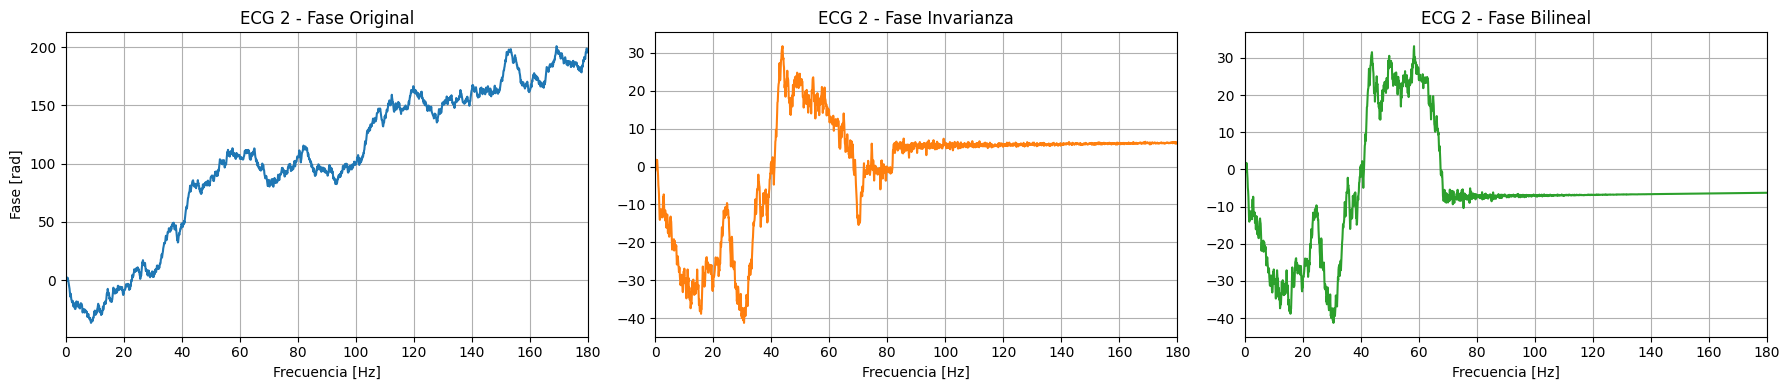

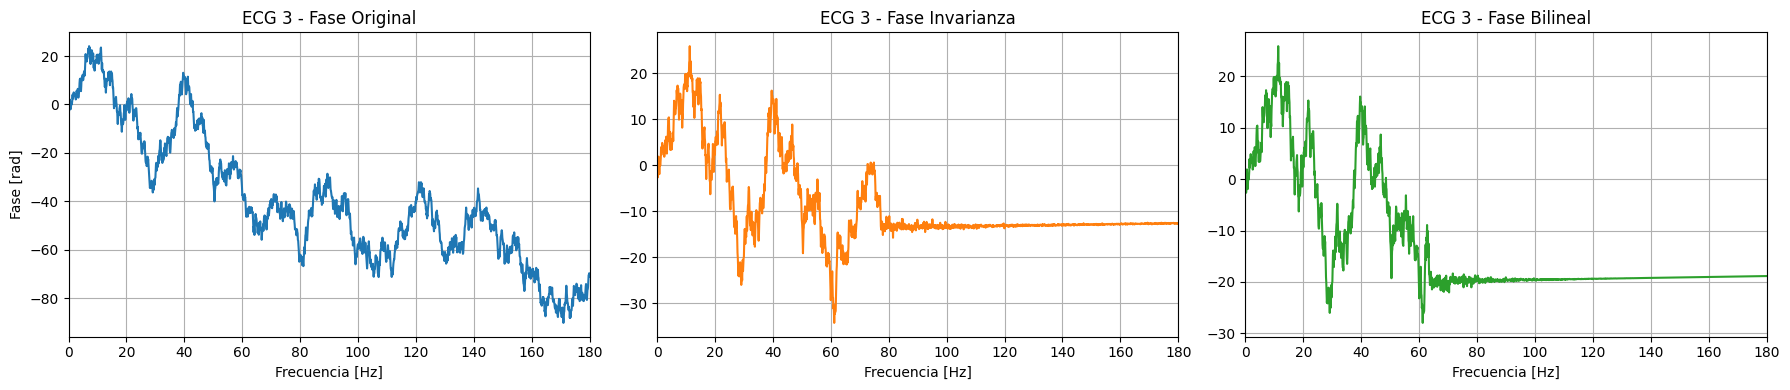

In [16]:
graficar_fase_en_columnas(
    senales,
    senales_filtradas_invar,
    senales_filtradas_bilin,
    fs,
    fmax=180
)


In [17]:
def graficar_respuesta_impulso(bz1, az1, bz2, az2, fs, N=100, metodo1="Invarianza", metodo2="Bilineal"):
    """
    Grafica la respuesta al impulso de dos sistemas (IIR) en una misma figura.

    Parámetros:
    - bz1, az1: coeficientes del filtro 1
    - bz2, az2: coeficientes del filtro 2
    - fs: frecuencia de muestreo
    - N: cantidad de muestras de la respuesta
    - metodo1, metodo2: etiquetas para los métodos
    """
    impulso = np.zeros(N)
    impulso[0] = 1  # delta discreta

    h1 = lfilter(bz1, az1, impulso)
    h2 = lfilter(bz2, az2, impulso)
    tiempo = np.arange(N) / fs

    plt.figure(figsize=(12, 4))
    plt.plot(tiempo, h1, label=f"Respuesta impulso - {metodo1}", color="tab:blue")
    plt.plot(tiempo, h2, label=f"Respuesta impulso - {metodo2}", color="tab:orange")
    plt.title("Respuesta al impulso unitario")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


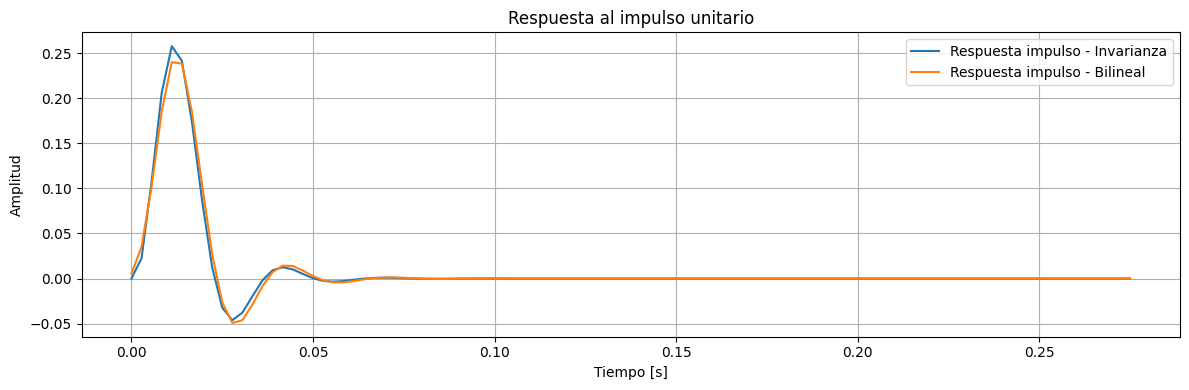

In [18]:
graficar_respuesta_impulso(
    bz_invar, az_invar,
    bz_bilin, az_bilin,
    fs,
    N=100,
    metodo1="Invarianza",
    metodo2="Bilineal"
)


DISEÑO FILTRO BLOQUEO BANDA

In [19]:
# === PARÁMETROS DEL FILTRO BLOQUEO BANDA ===
fs = 360                   # Frecuencia de muestreo (Hz)
fp1, fp2 = 58, 62          # Frecuencias de paso (Hz)
fs1, fs2 = 59, 61          # Frecuencias de bloqueo (Hz)
Ap = 1                     # Atenuación máxima en banda de paso (dB)
As = 20                    # Atenuación mínima en banda de rechazo (dB)

# === 1. Prewarping y diseño del filtro analógico ===
wp = [2 * fs * np.tan(np.pi * f / fs) for f in [fp1, fp2]]
ws = [2 * fs * np.tan(np.pi * f / fs) for f in [fs1, fs2]]
n, wn = buttord(wp, ws, Ap, As, analog=True)
b_notch, a_notch = butter(n, wn, btype='bandstop', analog=True)

print(f"Orden del filtro analógico: {n}")
print(f"Frecuencias de corte analógicas prewarpadas (Hz): {np.round(np.array(wn) / (2 * np.pi), 2)}")


Orden del filtro analógico: 5
Frecuencias de corte analógicas prewarpadas (Hz): [63.88 68.51]


In [20]:
# === 2. Transformación bilineal ===
bz_notch, az_notch = bilinear(b_notch, a_notch, fs)

# Calcular frecuencias digitales equivalentes
fp_digital, fs_digital = calcular_frecuencias_digitales_warp(wp, ws, fs)


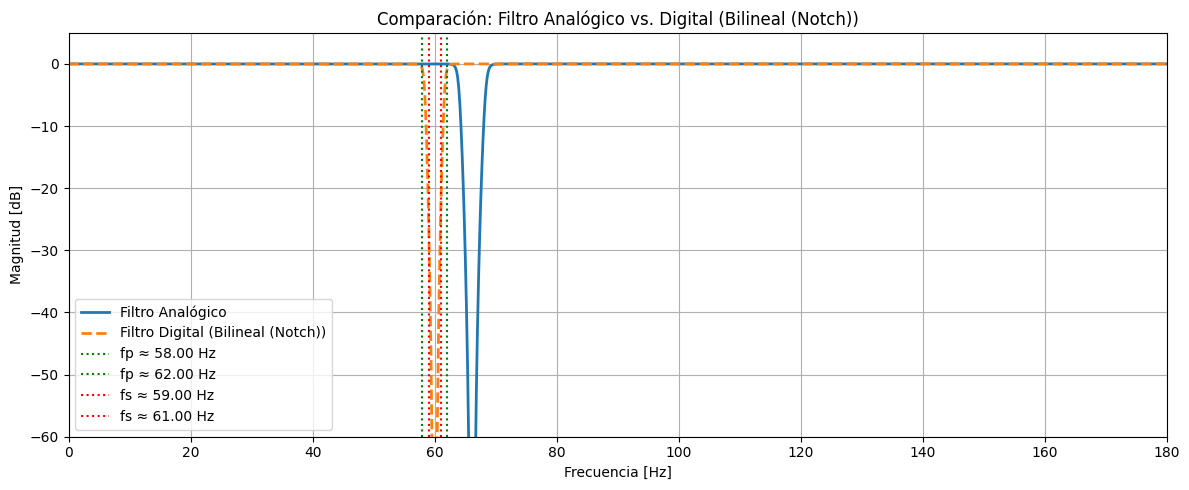

In [21]:
graficar_respuesta_frecuencia_comparada(
    b_notch, a_notch,
    bz_notch, az_notch,
    fs,
    fp=fp_digital,
    fs_rechazo=fs_digital,
    metodo="Bilineal (Notch)"
)


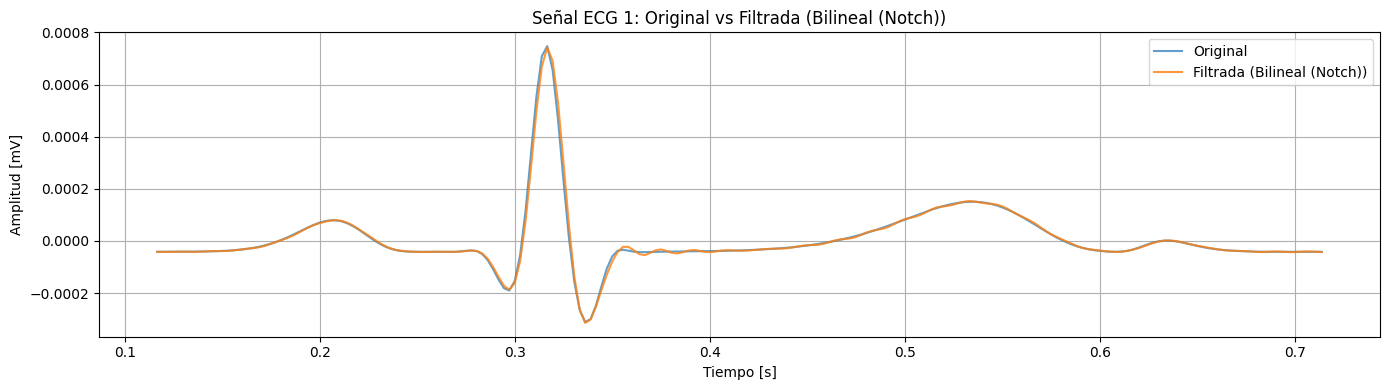

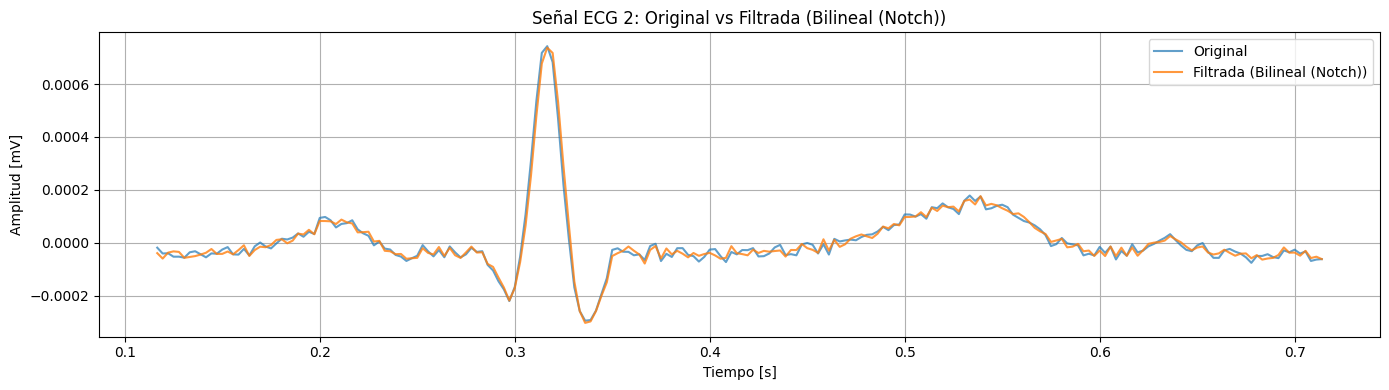

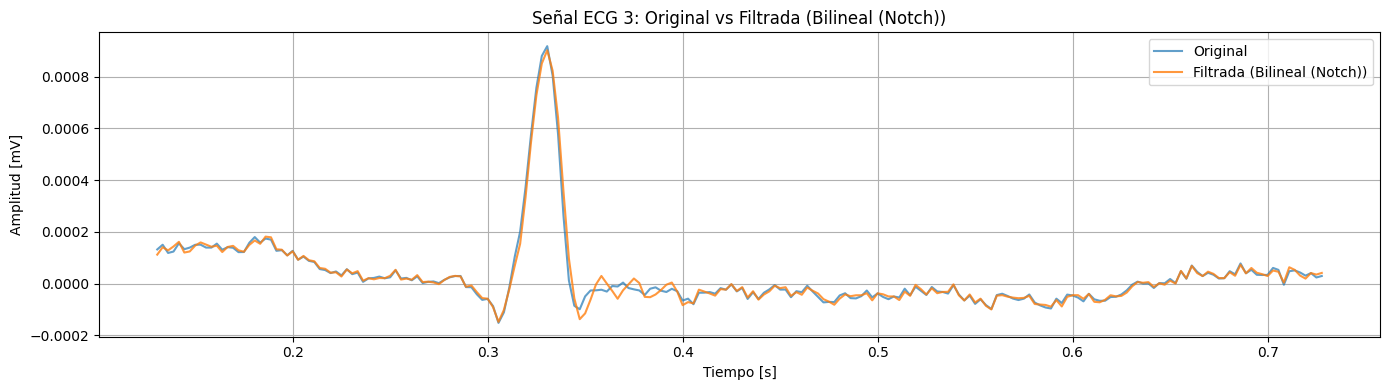

In [22]:
senales_filtradas_notch = [lfilter(bz_notch, az_notch, s) for s in senales]

graficar_ciclo_filtrado(
    senales,
    bz_notch, az_notch,
    fs,
    metodo="Bilineal (Notch)"
)


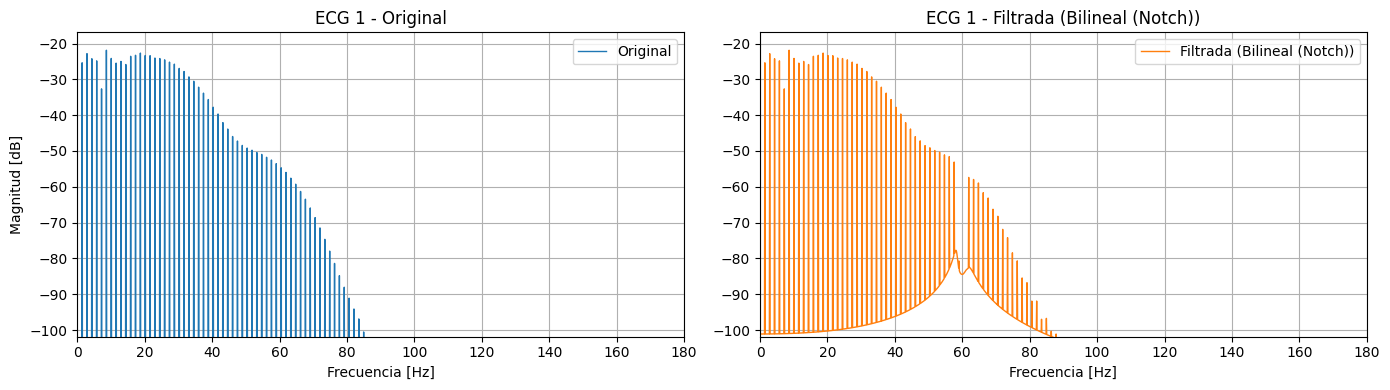

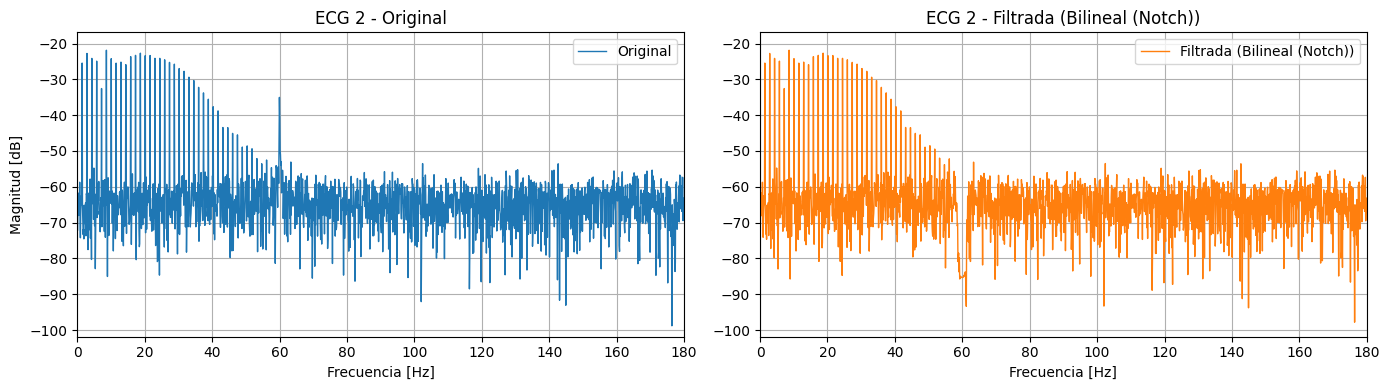

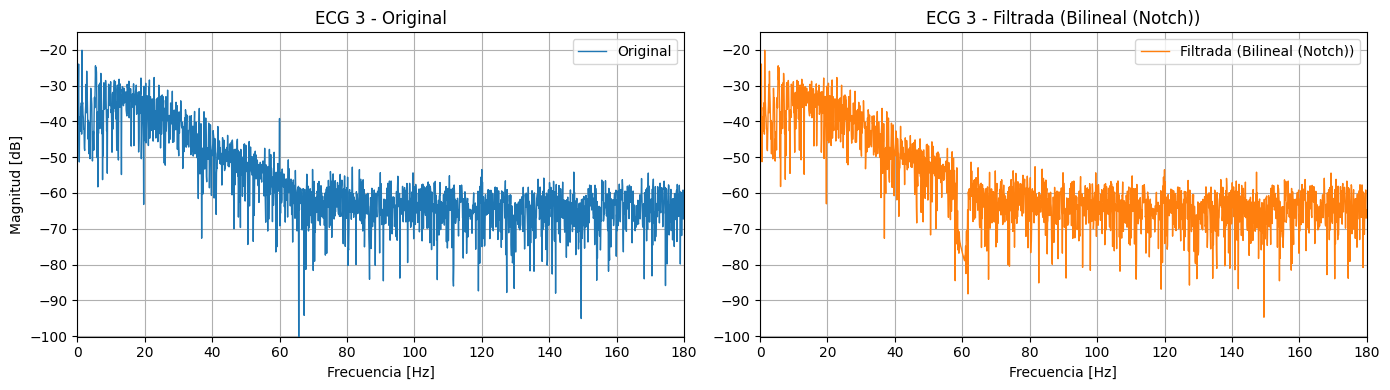

In [23]:
graficar_fft_comparativa(
    senales,
    senales_filtradas_notch,
    fs,
    fmax=180,
    metodo="Bilineal (Notch)"
)


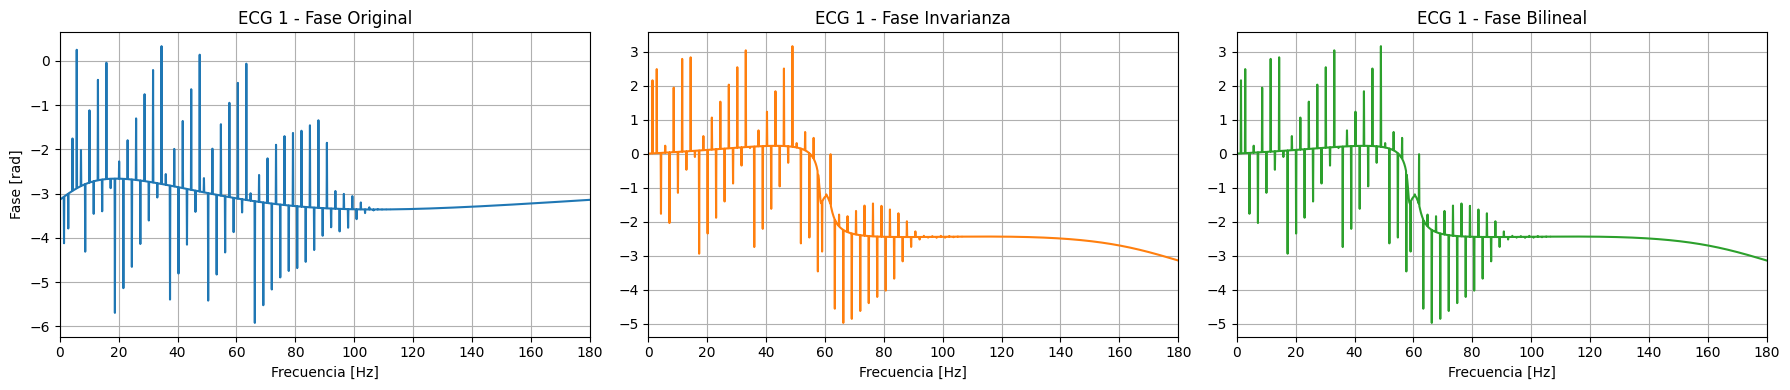

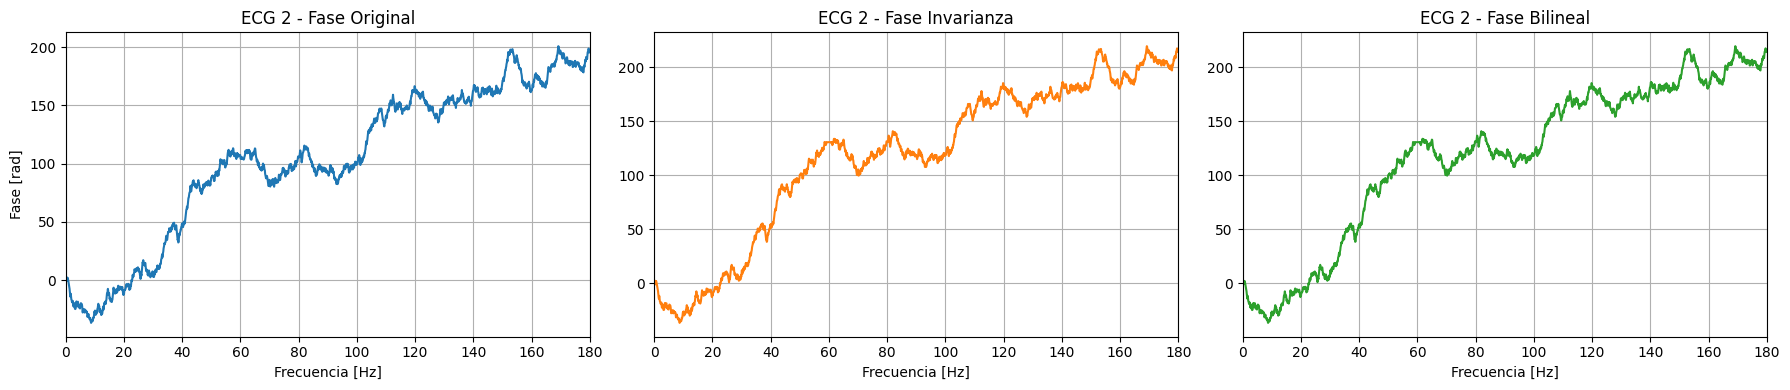

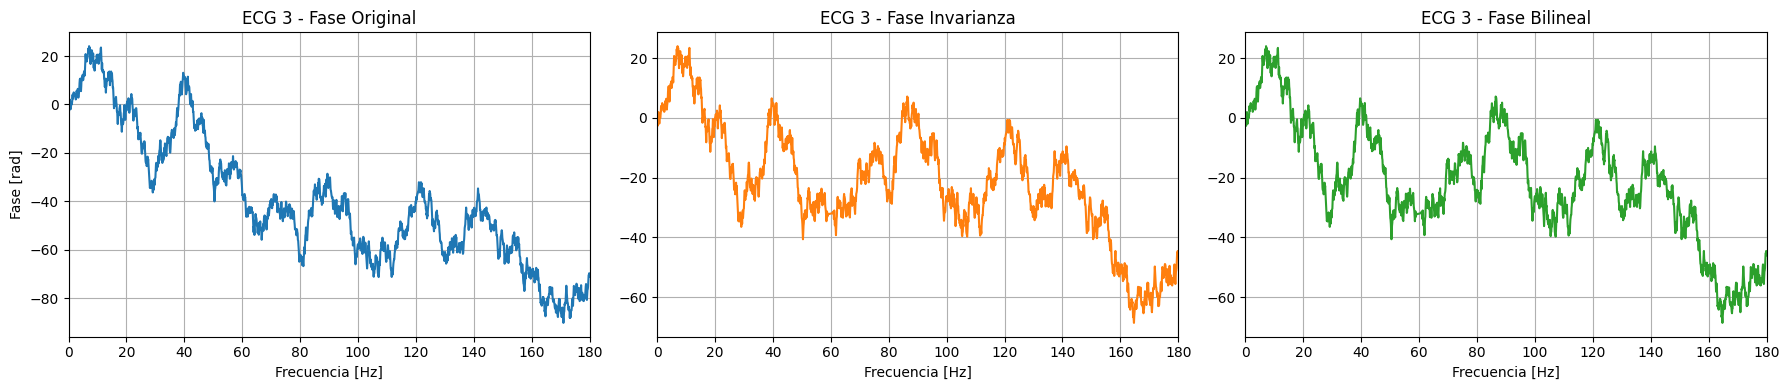

In [24]:
graficar_fase_en_columnas(
    senales,
    senales_filtradas_notch,
    senales_filtradas_notch,
    fs,
    fmax=180
)


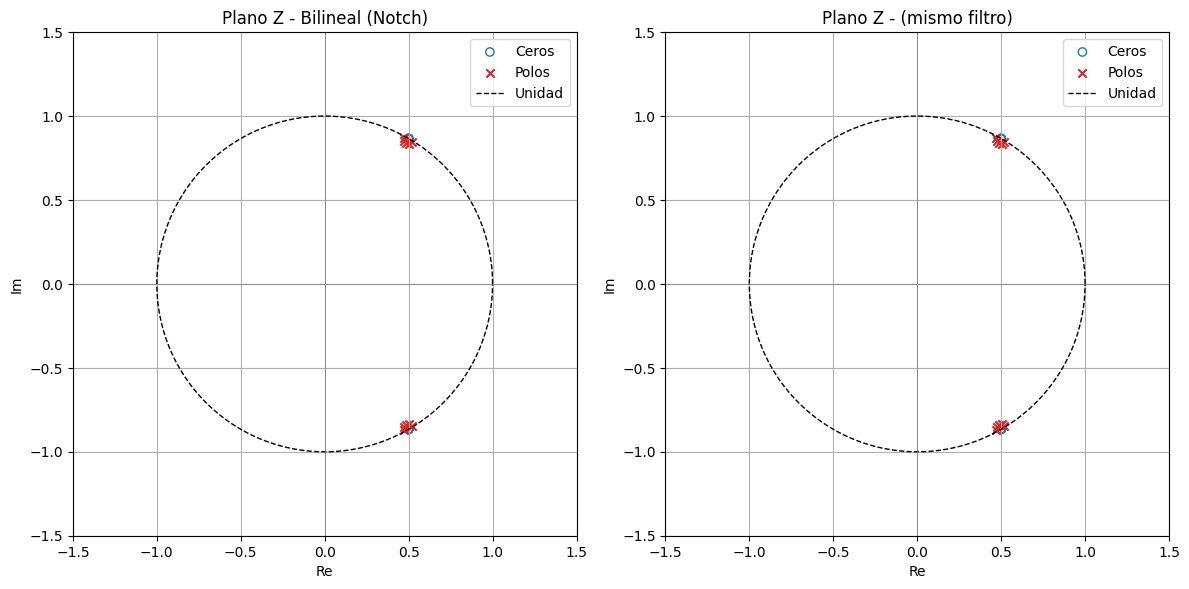

In [25]:
graficar_polos_ceros_digitales_separados(
    bz_notch, az_notch,
    bz_notch, az_notch,
    metodo1="Bilineal (Notch)",
    metodo2="(mismo filtro)"
)


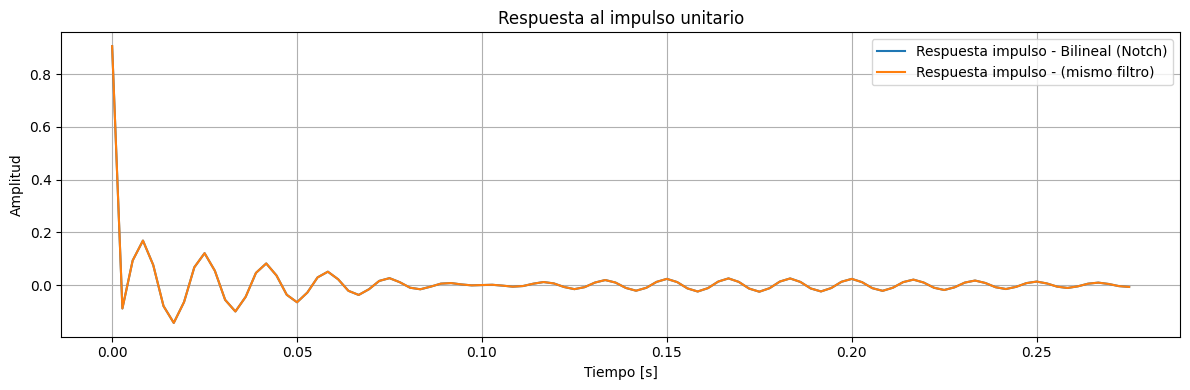

In [26]:
graficar_respuesta_impulso(
    bz_notch, az_notch,
    bz_notch, az_notch,
    fs,
    N=100,
    metodo1="Bilineal (Notch)",
    metodo2="(mismo filtro)"
)


IMPLEMENTACIÓN EN CASCADA

In [27]:
def celda_segundo_orden(xn, coef, estado):
    b0, b1, b2, a1, a2 = coef
    w1, w2 = estado
    wn = xn - a1 * w1 - a2 * w2
    yn = b0 * wn + b1 * w1 + b2 * w2
    estado[1] = w1
    estado[0] = wn
    return yn

def filtro_cascada(xn, celdas_coef, estados):
    for i in range(len(celdas_coef)):
        xn = celda_segundo_orden(xn, celdas_coef[i], estados[i])
    return xn


In [28]:
def procesar_senal(senal, celdas_coef):
    estados = [[0.0, 0.0] for _ in celdas_coef]
    salida = []

    t0 = time.perf_counter()

    for xn in senal:
        yn = filtro_cascada(xn, celdas_coef, estados)
        salida.append(yn)

    t1 = time.perf_counter()

    tiempo_total = t1 - t0
    tiempo_por_muestra = tiempo_total / len(senal) * 1e6  # µs

    return np.array(salida), tiempo_total, tiempo_por_muestra


In [29]:
from scipy.signal import tf2sos

# Pasa bajos con invarianza al impulso
sos_pasa_invar = tf2sos(bz_invar, az_invar)
celdas_invar = [(s[0], s[1], s[2], s[4], s[5]) for s in sos_pasa_invar]

# Pasa bajos con bilineal
sos_pasa_bilin = tf2sos(bz_bilin, az_bilin)
celdas_bilin = [(s[0], s[1], s[2], s[4], s[5]) for s in sos_pasa_bilin]

# Bloqueo banda bilineal
sos_notch = tf2sos(bz_notch, az_notch)
celdas_notch = [(s[0], s[1], s[2], s[4], s[5]) for s in sos_notch]


In [30]:
# Configuración 1: Invarianza al impulso + Notch
cascada_invar_notch = celdas_invar + celdas_notch

# Configuración 2: Bilineal + Notch
cascada_bilin_notch = celdas_bilin + celdas_notch


In [31]:
from copy import deepcopy

# Procesamiento
senales_proc_invar_notch = [procesar_senal(s, deepcopy(cascada_invar_notch))[0] for s in senales]
senales_proc_bilin_notch = [procesar_senal(s, deepcopy(cascada_bilin_notch))[0] for s in senales]


In [32]:
def comparar_metodos_tiempo(
    senales,
    filtradas1,
    filtradas2,
    fs,
    metodo1="Método 1",
    metodo2="Método 2",
    solo_filtradas=False
):
    """
    Compara visualmente las señales filtradas con dos métodos diferentes.

    Parámetros:
    - senales: lista de señales originales
    - filtradas1: señales filtradas con el primer método
    - filtradas2: señales filtradas con el segundo método
    - fs: frecuencia de muestreo
    - metodo1: nombre del primer método
    - metodo2: nombre del segundo método
    - solo_filtradas: si True, no muestra la señal original
    """
    for i, (original, f1, f2) in enumerate(zip(senales, filtradas1, filtradas2), 1):
        altura_minima = 0.5 * (np.max(original) - np.min(original)) + np.min(original)
        distancia_minima = int(0.25 * fs)
        picos, _ = find_peaks(original, height=altura_minima, distance=distancia_minima)

        if len(picos) == 0:
            print(f"No se detectaron picos R en la señal {i}.")
            continue

        centro = picos[0]
        pre = int(0.2 * fs)
        post = int(0.4 * fs)
        inicio = max(0, centro - pre)
        fin = min(len(original), centro + post)
        tiempo = np.arange(inicio, fin) / fs

        plt.figure(figsize=(14, 4))

        # Izquierda
        plt.subplot(1, 2, 1)
        if not solo_filtradas:
            plt.plot(tiempo, original[inicio:fin], label="Original", alpha=0.6)
        plt.plot(tiempo, f1[inicio:fin], label=f"{metodo1}", alpha=0.9)
        plt.title(f"ECG {i} - {metodo1}")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud [mV]")
        plt.grid(True)
        plt.legend()

        # Derecha
        plt.subplot(1, 2, 2)
        if not solo_filtradas:
            plt.plot(tiempo, original[inicio:fin], label="Original", alpha=0.6)
        plt.plot(tiempo, f2[inicio:fin], label=f"{metodo2}", alpha=0.9)
        plt.title(f"ECG {i} - {metodo2}")
        plt.xlabel("Tiempo [s]")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()


In [33]:
def comparar_fft_metodos(senales, filtradas_invar, filtradas_bilin, fs, fmax=None):
    """
    Compara visualmente los espectros (en dB) de las señales originales, filtradas por invarianza y por bilineal.

    Cada ECG se grafica con 3 espectros uno al lado del otro.
    """
    if fmax is None:
        fmax = fs / 2

    for i, (x, y_invar, y_bilin) in enumerate(zip(senales, filtradas_invar, filtradas_bilin), 1):
        N = len(x)
        frecs = fftfreq(N, 1/fs)
        idx_pos = frecs > 0
        frecs = frecs[idx_pos]

        X = fft(x)
        Y_invar = fft(y_invar)
        Y_bilin = fft(y_bilin)

        X_db = 20 * np.log10(np.abs(X[idx_pos]) + 1e-12)
        Y_invar_db = 20 * np.log10(np.abs(Y_invar[idx_pos]) + 1e-12)
        Y_bilin_db = 20 * np.log10(np.abs(Y_bilin[idx_pos]) + 1e-12)

        ymax = max(np.max(X_db), np.max(Y_invar_db), np.max(Y_bilin_db))
        ymin = ymax - 80

        plt.figure(figsize=(18, 4))
        plt.subplot(1, 3, 1)
        plt.plot(frecs, X_db, label="Original", color="tab:blue")
        plt.title(f"ECG {i} - Original")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Magnitud [dB]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(frecs, Y_invar_db, label="Invarianza", color="tab:orange")
        plt.title(f"ECG {i} - Invarianza al impulso")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(frecs, Y_bilin_db, label="Bilineal", color="tab:green")
        plt.title(f"ECG {i} - Bilineal")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.tight_layout()
        plt.show()


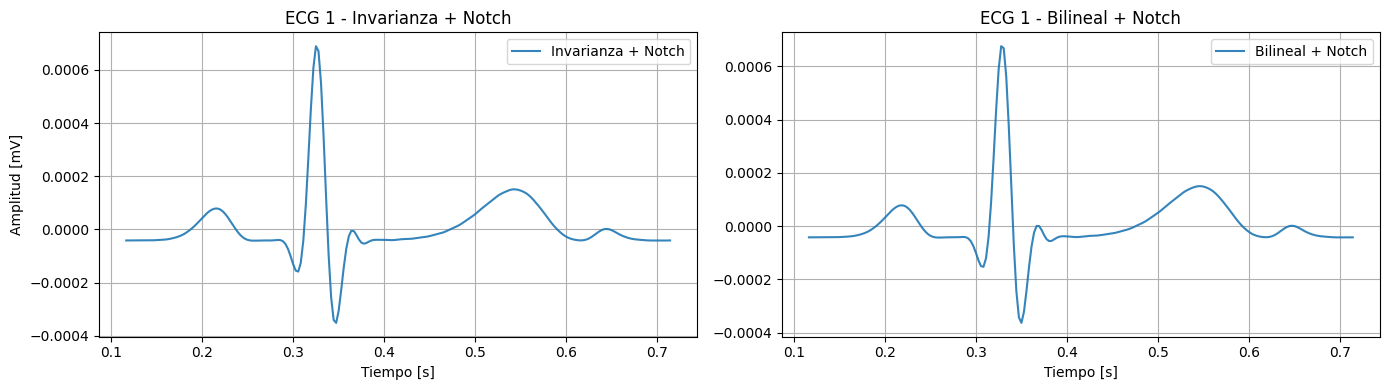

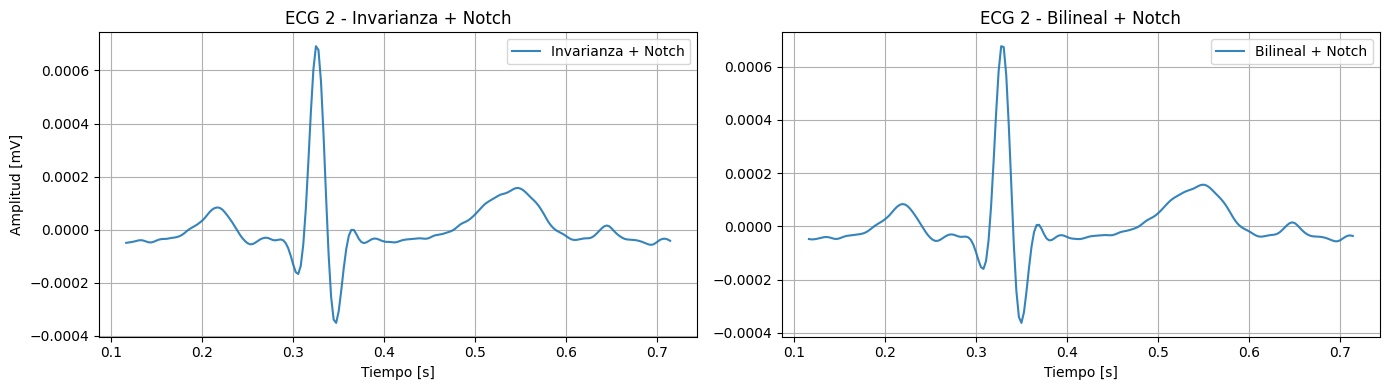

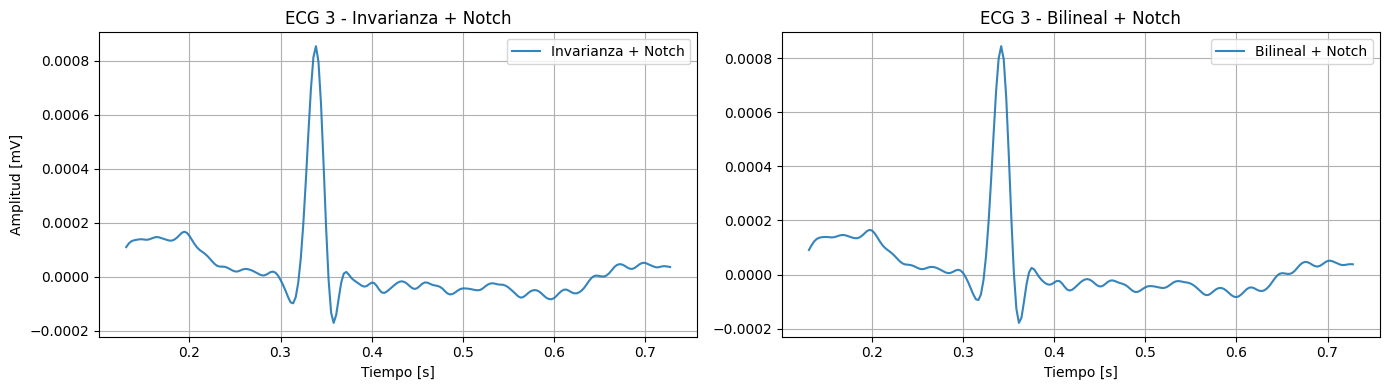

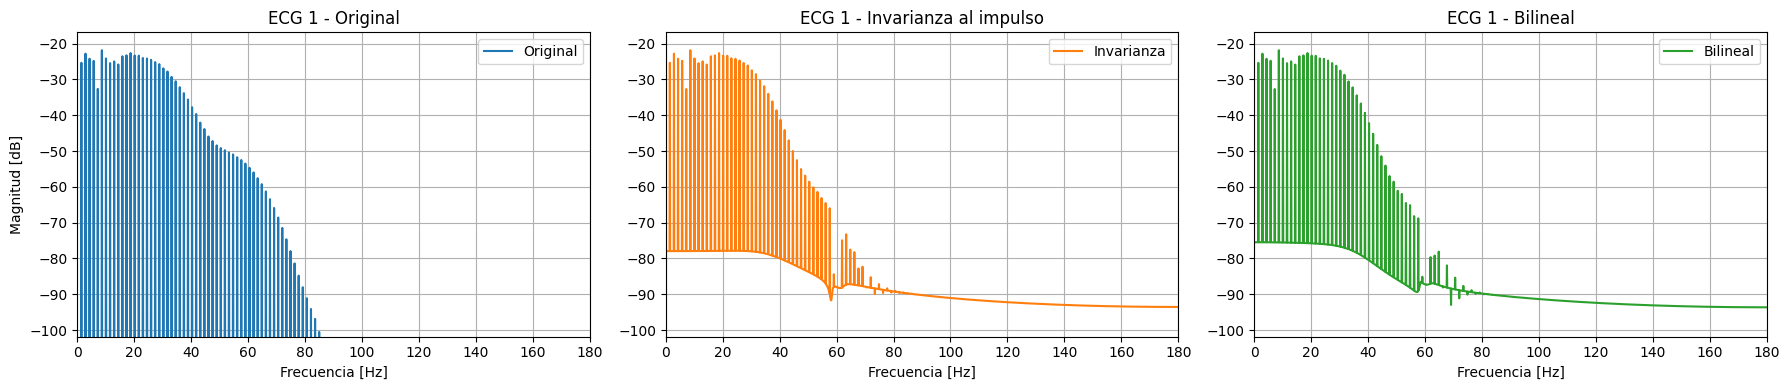

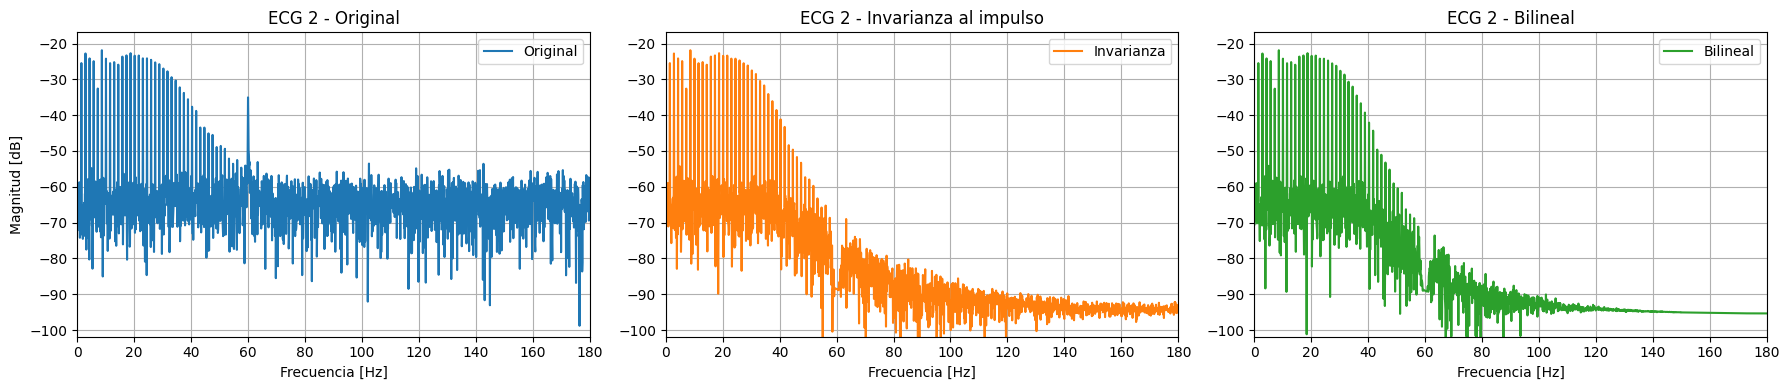

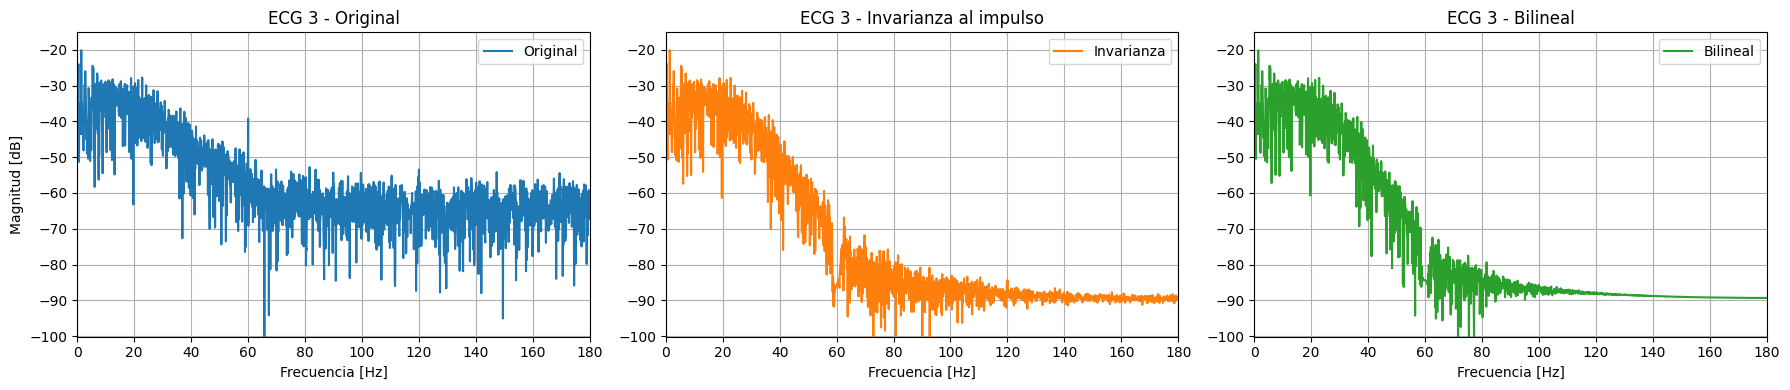

In [34]:
comparar_metodos_tiempo(
    senales,
    senales_proc_invar_notch,
    senales_proc_bilin_notch,
    fs,
    metodo1="Invarianza + Notch",
    metodo2="Bilineal + Notch",
    solo_filtradas=True
)

comparar_fft_metodos(
    senales,
    senales_proc_invar_notch,
    senales_proc_bilin_notch,
    fs,
    fmax=180
)
